# LibraryThing Recommender System

In [1]:
from collections import defaultdict
import ast
import random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy.optimize
import sklearn as skl
import tarfile
import json
import itertools

In [2]:
tar = tarfile.open("lthing_data.tar.gz", "r:gz") #found in https://cseweb.ucsd.edu/~jmcauley/datasets.html
for member in tar.getmembers():
     f = tar.extractfile(member)
     if f is not None:
         content = f.readlines()

In [3]:
data = [ast.literal_eval(c.decode("utf-8")) for c in content]

In [4]:
data[0]

{'work': '3206242',
 'flags': [],
 'unixtime': 1194393600,
 'stars': 5.0,
 'nhelpful': 0,
 'time': 'Nov 7, 2007',
 'comment': 'This a great book for young readers to be introduced to the world of Middle Earth. ',
 'user': 'van_stef'}

## Exploratory Analysis

#### dataframe statistics (dimensions, dtypes)

In [5]:
df = pd.DataFrame(data)
df.head()

,work,flags,unixtime,stars,nhelpful,time,comment,user
0,3206242,[],1.194394e+09,5.0,0,"Nov 7, 2007",This a great book for young readers to be intr...,van_stef
1,12198649,[],1.333757e+09,5.0,0,"Apr 7, 2012",Help Wanted: Tales of On The Job Terror from E...,dwatson2
2,12533765,[],1.352938e+09,NaN,0,"Nov 15, 2012","Magoon, K. (2012). Fire in the streets. New Yo...",edspicer
3,12981302,[],1.364515e+09,4.0,0,"Mar 29, 2013","Well, I definitely liked this book better than...",amdrane2
4,5231009,[],1.270944e+09,3.0,0,"Apr 11, 2010",It's a nice science-fiction thriller with some...,Lila_Gustavus


In [6]:
df.shape

(1707070, 8)

In [7]:
df.dtypes

work         object
flags        object
unixtime    float64
stars       float64
nhelpful      int64
time         object
comment      object
user         object
dtype: object

#### set of works (book ids?)

In [8]:
len(set(df['work']))

506165

In [9]:
df.groupby('work')['user'].count().sort_values(ascending=False).head(10)

work
4979986    2439
8384326    1835
1541442    1354
393681     1224
8662515    1165
3577382    1154
8019757    1097
9279041    1067
1222607    1018
3067       1013
Name: user, dtype: int64

In [10]:
df.groupby('work')['user'].get_group('4979986')

539        SarahRamon1416
1266          GodOcookies
1436       BriannaGratien
3583           eileenmary
3628        Book_Mountain
                ...      
1705090       qwerasdfzxc
1705888      bookaddict85
1706156       MMWiseheart
1706488     VenusofUrbino
1706734            Squeex
Name: user, Length: 2439, dtype: object

In [94]:
sum(df.groupby('work')['user'].count()<10)

454728

<AxesSubplot:>

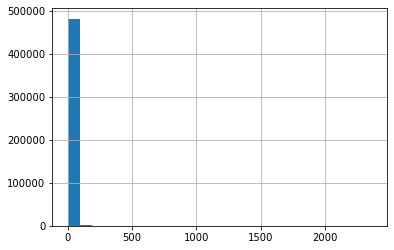

In [176]:
df.groupby('work')['user'].count().hist(bins=25)

<AxesSubplot:>

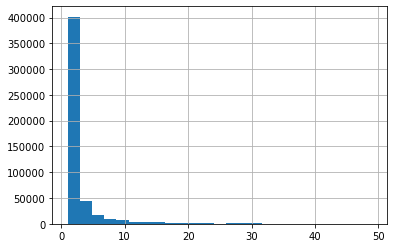

In [12]:
df.groupby('work')['user'].count()[df.groupby('work')['user'].count()<50].hist(bins=25)

#### flags

In [13]:
len([d for d in df['flags'] if d != []])

71120

In [14]:
set(list(itertools.chain(*[d for d in df['flags'] if d != []])))

{'abuse', 'not_a_review'}

#### bar plot of ratings, nan set to 0, no natural 0s

In [113]:
np.mean(df['stars']>=4)

0.5186906690302271

Text(0.5, 0, 'Stars')

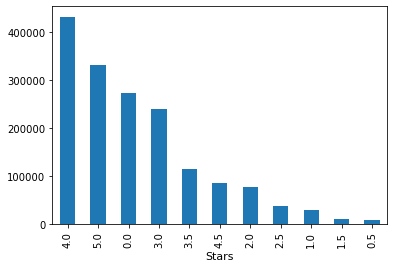

In [106]:
df['stars'].fillna(0).value_counts().plot.bar()
plt.xlabel('Stars',size=11)

#### histogram of helpful count

In [16]:
df['nhelpful'].value_counts()

0      1525971
1       130014
2        28665
3         9934
4         4348
        ...   
65           1
66           1
67           1
68           1
332          1
Name: nhelpful, Length: 83, dtype: int64

In [17]:
# less than 1% of nonzero data greater than 25
sum(df['nhelpful']>25)

155

In [118]:
np.mean(df['nhelpful']<=5)

0.9965078394816468

<AxesSubplot:>

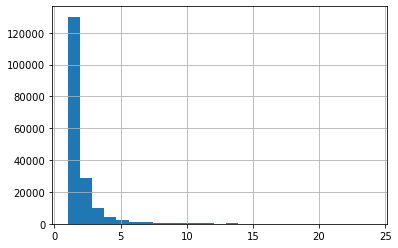

In [18]:
# cut off zeroes and extremes
df['nhelpful'][df['nhelpful']>0][df['nhelpful']<25].hist(bins=25)

#### unixtime / time simplified to year

<AxesSubplot:>

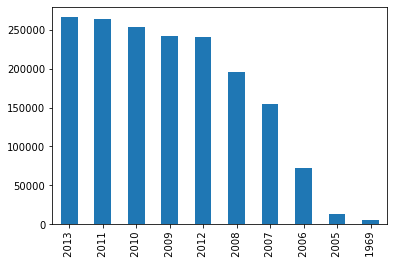

In [19]:
df['time'].str.slice(-5).value_counts().plot.bar()

#### comment length

<AxesSubplot:>

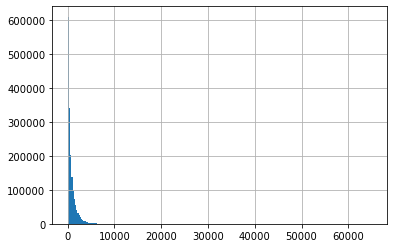

In [20]:
df['comment'].apply(len).hist(bins=250)

In [145]:
max(df['comment'].apply(len)) 

64234

<AxesSubplot:>

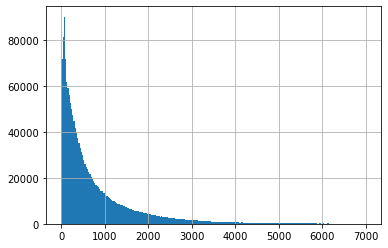

In [22]:
df['comment'].apply(len)[df['comment'].apply(len) < 7000].sort_values().hist(bins=250)

In [23]:
df['comment'].apply(len).value_counts()

84       7564
83       5261
8        5073
4        4110
47       3714
         ... 
8867        1
7413        1
7639        1
11507       1
8724        1
Name: comment, Length: 10477, dtype: int64

#### count of users

In [24]:
len(set(df['user']))

83195

In [131]:
df.groupby('user')['work'].count().sort_values(ascending=False).head(10)

user
kijabi1         5620
bluetyson       5380
Schmerguls      4763
roxy            4265
wyvernfriend    4246
GeniusJen       4155
vdb             3537
burnit99        3384
jon1lambert     3218
nwhyte          2906
Name: work, dtype: int64

In [141]:
np.mean(df.groupby('user')['work'].count()==1)

0.31115240720685244

In [127]:
df.groupby('user')['work'].count().sort_values(ascending=False)

user
kijabi1           5620
bluetyson         5380
Schmerguls        4763
roxy              4265
wyvernfriend      4246
                  ... 
Shannonmatarau       1
leobold1             1
Shanshad             1
leobabe              1
zzzbbb               1
Name: work, Length: 81256, dtype: int64

<AxesSubplot:>

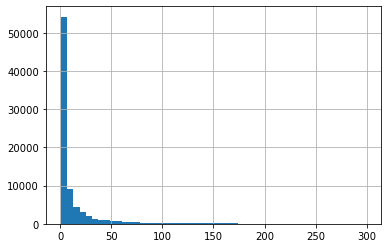

In [27]:
df.groupby('user')['work'].count()[df.groupby('user')['work'].count()<300].hist(bins=50)

## 2. Set up data for recommendor systems implementation. Create train/validation set, double validation set by creating negatives for training

In [28]:
# remove flagged data
df = df[df['flags'].astype(str)== '[]']
df = df[['work','stars','nhelpful','comment','user']]

In [68]:
train = df[:-10000].reset_index()
train['comment'] = train['comment'].apply(len)
train = train.drop(columns='index')
valid = df[-10000:].reset_index()
valid = valid[['work','user','stars','nhelpful']]

In [69]:
train.head(1)

,work,stars,nhelpful,comment,user
0,3206242,5.0,0,83,van_stef


In [70]:
valid.head(1)

,work,user,stars,nhelpful
0,24671,Thalia,4.0,0


In [32]:
userList = set(train['user'])
workList = set(train['work'])

# Utility data structures
reviewsPerUser = train.groupby('user')
reviewsPerWork = train.groupby('work')
usersPerWork = train.groupby('work')['user']
worksPerUser = train.groupby('user')['work']

# .get_group(str)

In [71]:
train = train.fillna(0)

In [72]:
workStarMean = train.groupby('work')['stars'].mean()

In [73]:
userHelpMean = train.groupby('user')['nhelpful'].mean()

In [89]:
valid = valid.fillna(0)

In [34]:
'birdg47' in userList

False

In [35]:
nullPairs = []
prev = None

for user in valid['user']:
    if user not in userList:
        user = prev
    neg = workList - set(worksPerUser.get_group(user))
    rItem = random.choice(list(neg))
    nullPairs += [[rItem, user]]
    prev = user

In [86]:
temp = [n + [workStarMean[n[0]],userHelpMean[n[1]]] for n in nullPairs]

In [85]:
valid = valid.append(pd.DataFrame(temp,index=range(10000,20000),columns=['work','user','stars','nhelpful']))
valid['read'] = [1]*10000 + [0]*10000

### popularity

In [90]:
mostPopular = usersPerWork.count().sort_values(ascending=False)
return1 = set()
count = 0

for index, value in mostPopular.items():
    count += value
    return1.add(index)
    if count > len(train)//2: break
        
valid['popular'] = valid['work'].isin(return1).astype(int)

valid

,work,user,stars,nhelpful,read,popular
0,24671,Thalia,4.0,0.000000,1,1
1,435827,LMClibrary,0.0,0.000000,1,0
2,10261765,pollywannabook,5.0,0.000000,1,1
3,5927153,aleya79,4.5,3.000000,1,1
4,8574826,chrystalm,5.0,0.000000,1,1
...,...,...,...,...,...,...
19995,385125,Jellyn,5.0,0.032609,0,0
19996,5542886,ShanaPat,4.0,0.026316,0,0
19997,1789647,koeniel,1.5,0.681818,0,0
19998,1724195,Ductor,5.0,0.343750,0,0


In [91]:
np.mean(valid['popular'] == valid['read'])

0.7234

In [39]:
accs = []
for threshold in [x*.01 for x in range(0,101)]:
    pop = set()
    count = 0

    for index, value in mostPopular.items():
        count += value
        pop.add(index)
        if count > threshold*len(train): break
 
    valid['popular'] = valid['work'].isin(pop).astype(int)

    accs += [(np.mean(valid['popular'] == valid['read']), threshold)]

In [40]:
sorted(accs,reverse=True)[:5]

[(0.7501, 0.66),
 (0.75005, 0.67),
 (0.75005, 0.65),
 (0.74985, 0.64),
 (0.7497, 0.63)]

In [41]:
pop = set()
count = 0

for index, value in mostPopular.items():
    count += value
    pop.add(index)
    if count > 0.67*len(train): break

valid['popular'] = valid['work'].isin(pop).astype(int)

valid

,work,user,read,popular
0,24671,Thalia,1,1
1,435827,LMClibrary,1,0
2,10261765,pollywannabook,1,1
3,5927153,aleya79,1,1
4,8574826,chrystalm,1,1
...,...,...,...,...
19995,385125,Jellyn,0,0
19996,5542886,ShanaPat,0,0
19997,1789647,koeniel,0,0
19998,1724195,Ductor,0,0


### similarity

In [42]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

def predictPlay(threshold, jacInput):
    
    if jacInput[0][0] >= threshold:
        return 1
    return 0

def mostSimilarFast(w, u):
    if w not in workList or u not in userList:
        return (0,w)
    similarities = []
    works = worksPerUser.get_group(u)
    gUsers = usersPerWork.get_group(w)
    candidateUsers = set()
    for w2 in works:
        g2users = usersPerWork.get_group(w2)
        sim = Jaccard(set(gUsers), set(g2users))
        similarities.append((sim,w2))
    similarities.sort(reverse=True)
    if similarities == []:
        return (0,w)
    return similarities[0]

In [43]:
jacs = []
i = 0

for d in zip(valid['work'],valid['user']):
    jacs.append(mostSimilarFast(d[0],d[1]))
    i += 1
    if i%1000==0:
        print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [44]:
valid['jacs'] = [j[0] for j in jacs]

In [144]:
valid

,work,user,stars,nhelpful,read,popular
0,24671,Thalia,4.0,0.000000,1,1
1,435827,LMClibrary,0.0,0.000000,1,0
2,10261765,pollywannabook,5.0,0.000000,1,1
3,5927153,aleya79,4.5,3.000000,1,1
4,8574826,chrystalm,5.0,0.000000,1,1
...,...,...,...,...,...,...
19995,385125,Jellyn,5.0,0.032609,0,0
19996,5542886,ShanaPat,4.0,0.026316,0,0
19997,1789647,koeniel,1.5,0.681818,0,0
19998,1724195,Ductor,5.0,0.343750,0,0


In [46]:
jaccs = []

for thold in [x/1000 for x in range(0,1001)]:
    valid['jaccheck'] = (valid['jacs'] > thold).astype(int)

    jaccs += [(np.mean(valid['jaccheck'] == valid['read']),thold)]

In [47]:
sorted(jaccs, reverse=True)[:5]

[(0.73625, 0.022),
 (0.7362, 0.019),
 (0.73615, 0.016),
 (0.73605, 0.017),
 (0.73595, 0.02)]

In [48]:
valid['jaccheck'] = (valid['jacs'] > .016).astype(int)

In [49]:
np.mean(valid['jaccheck'] == valid['popular'])

0.8123

In [50]:
np.mean(valid['read'] == (valid['jaccheck'] & valid['popular']))

0.75035

In [51]:
andaccs = []

for threshold in [x*.01 for x in range(0,101)]:
    if len(str(threshold)) == 3:
        print(threshold)
    
    pop = set()
    count = 0

    for index, value in mostPopular.items():
        count += value
        pop.add(index)
        if count > threshold*len(train): break

    valid['popular'] = valid['work'].isin(pop).astype(int)
    
    for thold in [x/1000 for x in range(0,1001)]:
        valid['jaccheck'] = (valid['jacs'] > thold).astype(int)
        andaccs += [(np.mean(valid['read'] == (valid['jaccheck'] & valid['popular'])),threshold,thold)]

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.8
0.9
1.0


In [52]:
sorted(andaccs,reverse=True)[:5]

[(0.7591, 0.8, 0.014),
 (0.7591, 0.8, 0.011),
 (0.75905, 0.79, 0.011),
 (0.75905, 0.78, 0.011),
 (0.75905, 0.77, 0.011)]

In [53]:
pop = set()
count = 0

for index, value in mostPopular.items():
    count += value
    pop.add(index)
    if count > 0.79*len(train): break
        
valid['popular'] = valid['work'].isin(pop).astype(int)
valid['jaccheck'] = (valid['jacs'] > 0.01).astype(int)
valid

,work,user,read,popular,jacs,jaccheck
0,24671,Thalia,1,1,0.200000,1
1,435827,LMClibrary,1,0,0.000000,0
2,10261765,pollywannabook,1,1,0.259191,1
3,5927153,aleya79,1,1,0.085669,1
4,8574826,chrystalm,1,1,0.413934,1
...,...,...,...,...,...,...
19995,385125,Jellyn,0,0,0.000000,0
19996,5542886,ShanaPat,0,0,0.000000,0
19997,1789647,koeniel,0,1,0.002506,0
19998,1724195,Ductor,0,0,0.000000,0


In [54]:
oraccs = []

for threshold in [x*.01 for x in range(0,101)]:
    if len(str(threshold)) == 3:
        print(threshold)
    
    pop = set()
    count = 0

    for index, value in mostPopular.items():
        count += value
        pop.add(index)
        if count > threshold*len(train): break

    valid['popular'] = valid['work'].isin(pop).astype(int)
    
    for thold in [x/1000 for x in range(0,1001)]:
        valid['jaccheck'] = (valid['jacs'] > thold).astype(int)
        oraccs += [(np.mean(valid['read'] == (valid['jaccheck'] | valid['popular'])),threshold,thold)]

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.8
0.9
1.0


In [55]:
sorted(oraccs,reverse=True)[:5]

[(0.77415, 0.58, 0.103),
 (0.77415, 0.58, 0.102),
 (0.77415, 0.58, 0.101),
 (0.77415, 0.58, 0.1),
 (0.77405, 0.58, 0.105)]

In [150]:
valid['jacs']=[j[0] for j in jacs]

In [151]:
pop = set()
count = 0

for index, value in mostPopular.items():
    count += value
    pop.add(index)
    if count > .58*len(train): break

valid['popular'] = valid['work'].isin(pop).astype(int)

In [152]:
valid['jaccheck'] = (valid['jacs'] > .103).astype(int)

In [159]:
valid['starcheck'] = valid['stars'] >= 4
valid['helpcheck'] = valid['nhelpful'] >= np.mean(valid['nhelpful'])

In [193]:
np.mean(valid['jacs']>np.mean(valid['jacs']))

0.2763

In [163]:
np.mean(valid['starcheck'] == valid['read'])

0.57865

In [172]:
np.mean(valid['read'] == (valid['jaccheck'] | valid['popular']))

0.77415

In [186]:
np.mean((valid['jaccheck'] | valid['popular'])[:10000]==1)

0.6756

In [185]:
np.mean((valid['jaccheck'] | valid['popular'])[10000:]==0)

0.8727

In [188]:
(np.mean((valid['jaccheck'] | valid['popular'])[:10000]==1) + np.mean((valid['jaccheck'] | valid['popular'])[10000:]==0))/2

0.77415